# Audio Recognition for Security
A model will be developed to accurately recognize audio related to security threats, such as breaking glass. A pre-trained model will serve as the foundation for this development.

In [117]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import io
import os

## Utilizando Yamnet
https://www.kaggle.com/models/google/yamnet

In [118]:
model = hub.load('https://www.kaggle.com/models/google/yamnet/TensorFlow2/yamnet/1')

# Input: 3 seconds of silence as mono 16 kHz waveform samples.
waveform = np.zeros(3 * 16000, dtype=np.float32)

scores, embeddings, log_mel_spectrogram = model(waveform)
scores

<tf.Tensor: shape=(6, 521), dtype=float32, numpy=
array([[8.2512805e-08, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [8.2512805e-08, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [8.2512805e-08, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [8.2512805e-08, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [8.2512805e-08, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [8.2512805e-08, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)>

In [119]:
def class_names_from_csv(class_map_csv_text):
    """Returns a list of class labels corresponding to the score vector."""
    class_map_df = pd.read_csv(io.StringIO(class_map_csv_text))
    class_names = class_map_df['display_name'].tolist()
    return class_names

In [120]:
class_map_path = model.class_map_path().numpy()
class_names = class_names_from_csv(tf.io.read_file(class_map_path).numpy().decode('utf-8'))
class_names

['Speech',
 'Child speech, kid speaking',
 'Conversation',
 'Narration, monologue',
 'Babbling',
 'Speech synthesizer',
 'Shout',
 'Bellow',
 'Whoop',
 'Yell',
 'Children shouting',
 'Screaming',
 'Whispering',
 'Laughter',
 'Baby laughter',
 'Giggle',
 'Snicker',
 'Belly laugh',
 'Chuckle, chortle',
 'Crying, sobbing',
 'Baby cry, infant cry',
 'Whimper',
 'Wail, moan',
 'Sigh',
 'Singing',
 'Choir',
 'Yodeling',
 'Chant',
 'Mantra',
 'Child singing',
 'Synthetic singing',
 'Rapping',
 'Humming',
 'Groan',
 'Grunt',
 'Whistling',
 'Breathing',
 'Wheeze',
 'Snoring',
 'Gasp',
 'Pant',
 'Snort',
 'Cough',
 'Throat clearing',
 'Sneeze',
 'Sniff',
 'Run',
 'Shuffle',
 'Walk, footsteps',
 'Chewing, mastication',
 'Biting',
 'Gargling',
 'Stomach rumble',
 'Burping, eructation',
 'Hiccup',
 'Fart',
 'Hands',
 'Finger snapping',
 'Clapping',
 'Heart sounds, heartbeat',
 'Heart murmur',
 'Cheering',
 'Applause',
 'Chatter',
 'Crowd',
 'Hubbub, speech noise, speech babble',
 'Children playing'

In [121]:
def map_score_to_class(scores):
    return class_names[np.argmax(scores.numpy().mean(axis=0))]

In [122]:
map_score_to_class(scores)

'Silence'

## Using different audios

In [123]:
import librosa
import matplotlib.pyplot as plt

In [124]:
def load_audio(file_path):
    """
    Carrega um arquivo de áudio MP3 e retorna o waveform e a taxa de amostragem.

    Args:
    file_path (str): Caminho para o arquivo de áudio MP3.

    Returns:
    tuple: waveform (np.ndarray), sample_rate (int)
    """
    waveform, sample_rate = librosa.load(file_path, sr=None)
    return waveform, sample_rate

In [125]:
file_path = 'dog-barking-70772.mp3'
waveform, sample_rate = load_audio(file_path)
scores, embeddings, log_mel_spectrogram = model(waveform)

In [126]:
def plot_top_classes(scores, class_names, top_n=10):
    """
    Plota as top N classes mais prováveis com base nos scores.

    Args:
    scores (np.ndarray): Vetor de pontuações.
    class_names (list): Lista de nomes das classes.
    top_n (int): Número de top classes a serem visualizadas.
    """
    mean_scores = scores.mean(axis=0)
    top_indices = np.argsort(mean_scores)[-top_n:][::-1]
    top_scores = mean_scores[top_indices]
    top_class_names = [class_names[i] for i in top_indices]

    plt.figure(figsize=(10, 6))
    plt.barh(top_class_names, top_scores)
    plt.xlabel('Score')
    plt.ylabel('Class')
    plt.title(f'Top {top_n} Classes')
    plt.gca().invert_yaxis()
    plt.show()

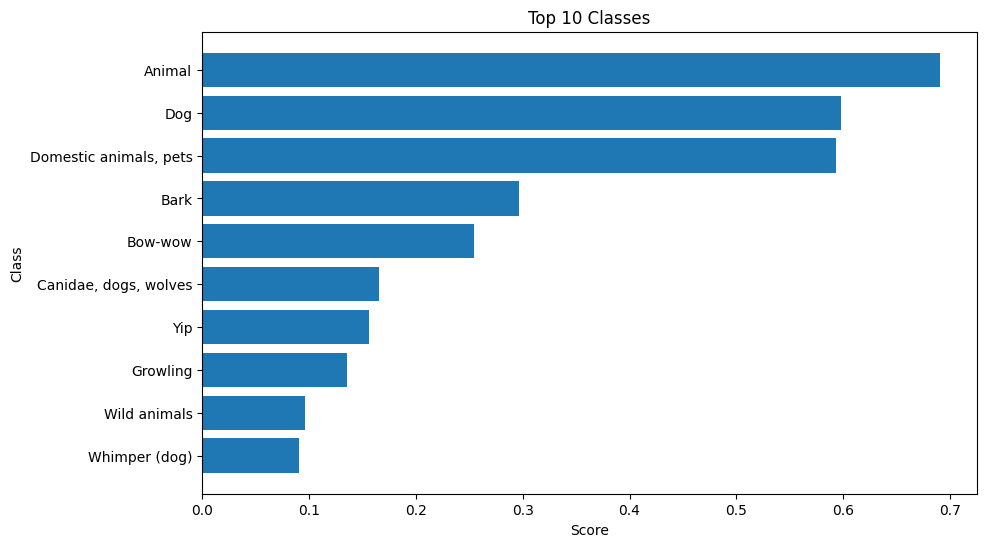

In [127]:
plot_top_classes(scores.numpy(), class_names)

## Loading a new dataset
This dataset has audio examples that are specific for our security problem.

In [128]:
_ = tf.keras.utils.get_file('esc-50.zip',
                        'https://github.com/karoldvl/ESC-50/archive/master.zip',
                        cache_dir='./',
                        cache_subdir='datasets',
                        extract=True)

In [129]:
esc50_csv = './datasets/ESC-50-master/meta/esc50.csv'
base_data_path = './datasets/ESC-50-master/audio/'

In [130]:
df = pd.read_csv(esc50_csv)
df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [131]:
df['category'].unique()

array(['dog', 'chirping_birds', 'vacuum_cleaner', 'thunderstorm',
       'door_wood_knock', 'can_opening', 'crow', 'clapping', 'fireworks',
       'chainsaw', 'airplane', 'mouse_click', 'pouring_water', 'train',
       'sheep', 'water_drops', 'church_bells', 'clock_alarm',
       'keyboard_typing', 'wind', 'footsteps', 'frog', 'cow',
       'brushing_teeth', 'car_horn', 'crackling_fire', 'helicopter',
       'drinking_sipping', 'rain', 'insects', 'laughing', 'hen', 'engine',
       'breathing', 'crying_baby', 'hand_saw', 'coughing',
       'glass_breaking', 'snoring', 'toilet_flush', 'pig',
       'washing_machine', 'clock_tick', 'sneezing', 'rooster',
       'sea_waves', 'siren', 'cat', 'door_wood_creaks', 'crickets'],
      dtype=object)

In [132]:
classes = ['dog', 'door_wood_creaks', 'glass_breaking']
mapeamento = {'dog':0, 'door_wood_creaks':1,'glass_breaking':2}

In [133]:
df_filtrado = df[df['category'].isin(classes)]
df_filtrado

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
14,1-110389-A-0.wav,1,0,dog,True,110389,A
95,1-20133-A-39.wav,1,39,glass_breaking,False,20133,A
157,1-30226-A-0.wav,1,0,dog,True,30226,A
158,1-30344-A-0.wav,1,0,dog,True,30344,A
...,...,...,...,...,...,...,...
1971,5-257642-A-39.wav,5,39,glass_breaking,False,257642,A
1979,5-260432-A-39.wav,5,39,glass_breaking,False,260432,A
1980,5-260433-A-39.wav,5,39,glass_breaking,False,260433,A
1981,5-260434-A-39.wav,5,39,glass_breaking,False,260434,A


In [134]:
# Aplicar o mapeamento usando loc
df_filtrado.loc[:, 'alvo'] = df_filtrado['category'].apply(lambda name: mapeamento[name])
full_path = df_filtrado['filename'].apply(lambda row: os.path.join(base_data_path, row))
df_filtrado = df_filtrado.assign(filename=full_path)
df_filtrado

/tmp/ipykernel_1641/2139507846.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado.loc[:, 'alvo'] = df_filtrado['category'].apply(lambda name: mapeamento[name])


,filename,fold,target,category,esc10,src_file,take,alvo
0,./datasets/ESC-50-master/audio/1-100032-A-0.wav,1,0,dog,True,100032,A,0
14,./datasets/ESC-50-master/audio/1-110389-A-0.wav,1,0,dog,True,110389,A,0
95,./datasets/ESC-50-master/audio/1-20133-A-39.wav,1,39,glass_breaking,False,20133,A,2
157,./datasets/ESC-50-master/audio/1-30226-A-0.wav,1,0,dog,True,30226,A,0
158,./datasets/ESC-50-master/audio/1-30344-A-0.wav,1,0,dog,True,30344,A,0
...,...,...,...,...,...,...,...,...
1971,./datasets/ESC-50-master/audio/5-257642-A-39.wav,5,39,glass_breaking,False,257642,A,2
1979,./datasets/ESC-50-master/audio/5-260432-A-39.wav,5,39,glass_breaking,False,260432,A,2
1980,./datasets/ESC-50-master/audio/5-260433-A-39.wav,5,39,glass_breaking,False,260433,A,2
1981,./datasets/ESC-50-master/audio/5-260434-A-39.wav,5,39,glass_breaking,False,260434,A,2


## Preprocessing

In [135]:
from scipy.signal import resample

def load_and_process_audio(filename, max_length=16000):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    
    def scipy_resample(wav, sample_rate):
        if sample_rate != 16000:
            wav = resample(wav, int(16000 / sample_rate * len(wav)))
        return wav
    
    wav = tf.py_function(scipy_resample, [wav, sample_rate], tf.float32)
    
    audio_length = tf.shape(wav)[0]
    if audio_length > max_length:
        wav = wav[:max_length]
    else:
        pad_length = max_length - audio_length
        paddings = [[0, pad_length]]
        wav = tf.pad(wav, paddings, 'CONSTANT')
        
    return tf.reshape(wav, [max_length])

In [136]:
def process_path(file_path, label, fold):
    audio = load_and_process_audio(file_path)
    label = tf.cast(label, tf.int64)
    fold = tf.cast(fold, tf.int64)
    return audio, label, fold

In [137]:
# Builds a Tensorflow Dataset
def paths_labels_folds_to_dataset(audio_paths, labels, folds):
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    fold_ds = tf.data.Dataset.from_tensor_slices(folds)
    audio_label_fold_ds = tf.data.Dataset.zip((path_ds, label_ds, fold_ds))
    return audio_label_fold_ds.map(lambda path, label, fold: tf.py_function(
        func=process_path, inp=[path, label, fold], Tout=[tf.float32, tf.int64, tf.int64]), num_parallel_calls=tf.data.AUTOTUNE)

In [138]:
def prepare_for_training(ds, batch_size=32, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.batch(batch_size)
    #ds = ds.repeat(repeat_count)  # adding repeat
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

In [139]:
# Loading the data from the dataframe
audio_paths = df_filtrado['filename'].tolist()
labels = df_filtrado['alvo'].tolist()
folds = df['fold'].tolist()

In [140]:
complete_dataset = paths_labels_folds_to_dataset(audio_paths, labels, folds)

## Transfer Learning

In [141]:
def extract_embedding(wav_data, label, fold):
    ''' run YAMNet to extract embedding from the wav data '''
    _, embeddings, _ = model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

In [142]:
complete_dataset = complete_dataset.map(extract_embedding).unbatch()

In [143]:
train_dataset = complete_dataset.filter(lambda audio, label, fold: fold < 5)  # folds 0-4 for training
val_dataset = complete_dataset.filter(lambda audio, label, fold: fold == 5)   # fold 5 for validation

train_dataset = prepare_for_training(train_dataset)
val_dataset = prepare_for_training(val_dataset)

## Building our model

In [144]:
import tensorflow as tf
import numpy as np
from scipy.signal import resample
from sklearn.preprocessing import LabelEncoder
import tensorflow_hub as hub

yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

def load_and_process_audio(filename, max_length=16000):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    
    def scipy_resample(wav, sample_rate):
        if sample_rate != 16000:
            wav = resample(wav, int(16000 / sample_rate * len(wav)))
        return wav

    wav = tf.py_function(scipy_resample, [wav, sample_rate], tf.float32)
    
    # Adding paddings or slicing the signal
    audio_length = tf.shape(wav)[0]
    if audio_length > max_length:
        wav = wav[:max_length]
    else:
        pad_length = max_length - audio_length
        paddings = [[0, pad_length]]
        wav = tf.pad(wav, paddings, "CONSTANT")
    
    return tf.reshape(wav, [max_length])

def process_path(file_path, label, fold):
    audio = load_and_process_audio(file_path)
    label = tf.cast(label, tf.int64)
    fold = tf.cast(fold, tf.int64)
    return audio, label, fold

# Builds a tensorflow dataset
def paths_labels_folds_to_dataset(audio_paths, labels, folds):
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    fold_ds = tf.data.Dataset.from_tensor_slices(folds)
    audio_label_fold_ds = tf.data.Dataset.zip((path_ds, label_ds, fold_ds))
    return audio_label_fold_ds.map(lambda path, label, fold: tf.py_function(
        func=process_path, inp=[path, label, fold], Tout=[tf.float32, tf.int64, tf.int64]), num_parallel_calls=tf.data.AUTOTUNE)

def prepare_for_training(ds, batch_size=32, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

def extract_embedding(wav_data, label, fold):
    ''' run YAMNet to extract embedding from the wav data '''
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

audio_paths = df_filtrado['filename'].tolist()
labels = df_filtrado['alvo'].tolist()
folds = df_filtrado['fold'].tolist()

complete_dataset = paths_labels_folds_to_dataset(audio_paths, labels, folds)

for audio, label, fold in complete_dataset.take(1):
    print(f"Audio shape: {audio.shape}")
    print(f"Label: {label}")
    print(f"Fold: {fold}")

complete_dataset = complete_dataset.map(extract_embedding).unbatch()

for embeddings, label, fold in complete_dataset.take(1):
    print(f"Embeddings shape: {embeddings.shape}")
    print(f"Label: {label}")
    print(f"Fold: {fold}")

train_dataset = complete_dataset.filter(lambda embeddings, label, fold: fold < 5)  # folds 1-4 for training
val_dataset = complete_dataset.filter(lambda embeddings, label, fold: fold == 5)   # fold 5 for validation

train_dataset = prepare_for_training(train_dataset)
val_dataset = prepare_for_training(val_dataset)

print(train_dataset.element_spec)
print(val_dataset.element_spec)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024,), dtype=tf.float32, name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(labels))) # Setting the loss functions as "SparseCategoricalCrossentropy" makes the last dense layer 
                                                  # return the probabilities like the softmax would do
])

model.summary()

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

history = model.fit(train_dataset,
                       epochs=20,
                       validation_data=val_dataset,
                       callbacks=[callback])

Audio shape: (16000,)
Label: 0
Fold: 1
Embeddings shape: (1024,)
Label: 0
Fold: 1
(TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))
(TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 526,339 (2.01 MB)

 Trainable params: 526,339 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


I0000 00:00:1727361533.149757    2322 service.cc:146] XLA service 0x7f53e4005c30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727361533.149919    2322 service.cc:154]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2024-09-26 14:38:53.199870: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-26 14:38:53.908528: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_111', 4 bytes spill stores, 4 bytes spill loads



      1/Unknown 3s 3s/step - accuracy: 0.3438 - loss: 2.8738

I0000 00:00:1727361534.914767    2322 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-09-26 14:38:54.927598: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17171313441932229212
2024-09-26 14:38:54.927640: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8078176627876363934
2024-09-26 14:38:54.927656: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3047218368728456900
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 487ms/step - accuracy: 0.6403 - loss: 1.9776 - val_accuracy: 0.9792 - val_loss: 1.0017
Epoch 2/20


2024-09-26 14:38:57.341165: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17171313441932229212
2024-09-26 14:38:57.341214: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3047218368728456900
2024-09-26 14:38:57.341236: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8078176627876363934


1/6 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9375 - loss: 0.8054

2024-09-26 14:38:58.522773: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17171313441932229212
2024-09-26 14:38:58.522818: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8078176627876363934
2024-09-26 14:38:58.522837: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3047218368728456900


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - accuracy: 0.9293 - loss: 0.5921 - val_accuracy: 0.9583 - val_loss: 0.5155
Epoch 3/20


2024-09-26 14:38:59.654500: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2024-09-26 14:38:59.654558: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17171313441932229212
2024-09-26 14:38:59.654569: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3047218368728456900
2024-09-26 14:38:59.654584: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8078176627876363934


1/6 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9375 - loss: 0.4868

2024-09-26 14:39:00.837281: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17171313441932229212
2024-09-26 14:39:00.837323: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8078176627876363934
2024-09-26 14:39:00.837339: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3047218368728456900


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - accuracy: 0.9420 - loss: 0.3875 - val_accuracy: 0.9583 - val_loss: 0.4301
Epoch 4/20


2024-09-26 14:39:02.048187: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17171313441932229212
2024-09-26 14:39:02.048232: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3047218368728456900
2024-09-26 14:39:02.048249: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8078176627876363934


1/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9688 - loss: 0.1943

2024-09-26 14:39:03.318650: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17171313441932229212
2024-09-26 14:39:03.318689: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8078176627876363934
2024-09-26 14:39:03.318706: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3047218368728456900


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - accuracy: 0.9570 - loss: 0.2653 - val_accuracy: 0.9583 - val_loss: 0.3840
Epoch 5/20


2024-09-26 14:39:04.464480: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17171313441932229212
2024-09-26 14:39:04.464527: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3047218368728456900
2024-09-26 14:39:04.464547: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8078176627876363934


1/6 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8750 - loss: 0.5447

2024-09-26 14:39:05.635476: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8078176627876363934
2024-09-26 14:39:05.635520: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3047218368728456900


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - accuracy: 0.9426 - loss: 0.2992 - val_accuracy: 0.9583 - val_loss: 0.4024
Epoch 6/20


2024-09-26 14:39:06.772256: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17171313441932229212
2024-09-26 14:39:06.772320: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3047218368728456900
2024-09-26 14:39:06.772341: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8078176627876363934


1/6 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 1.0000 - loss: 0.0296

2024-09-26 14:39:07.949316: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17171313441932229212
2024-09-26 14:39:07.949361: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8078176627876363934
2024-09-26 14:39:07.949380: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3047218368728456900


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - accuracy: 0.9854 - loss: 0.1291 - val_accuracy: 0.9583 - val_loss: 0.4230
Epoch 7/20


2024-09-26 14:39:09.078215: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17171313441932229212
2024-09-26 14:39:09.078266: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3047218368728456900
2024-09-26 14:39:09.078288: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8078176627876363934


1/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 1.0000 - loss: 0.2092

2024-09-26 14:39:10.362230: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17171313441932229212
2024-09-26 14:39:10.362275: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8078176627876363934
2024-09-26 14:39:10.362296: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3047218368728456900


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step - accuracy: 0.9806 - loss: 0.1664 - val_accuracy: 0.9583 - val_loss: 0.4489
Epoch 8/20


2024-09-26 14:39:11.557485: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17171313441932229212
2024-09-26 14:39:11.557535: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3047218368728456900
2024-09-26 14:39:11.557555: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8078176627876363934


1/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9688 - loss: 0.1946

2024-09-26 14:39:12.839094: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8078176627876363934


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - accuracy: 0.9679 - loss: 0.1349 - val_accuracy: 0.9583 - val_loss: 0.4847
Epoch 9/20


2024-09-26 14:39:13.983002: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17171313441932229212
2024-09-26 14:39:13.983050: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3047218368728456900
2024-09-26 14:39:13.983072: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8078176627876363934


1/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9688 - loss: 0.1292

2024-09-26 14:39:15.438026: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17171313441932229212
2024-09-26 14:39:15.438066: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8078176627876363934
2024-09-26 14:39:15.438087: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3047218368728456900


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - accuracy: 0.9786 - loss: 0.1040 - val_accuracy: 0.9583 - val_loss: 0.5175
Epoch 10/20


2024-09-26 14:39:16.648333: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17171313441932229212
2024-09-26 14:39:16.648378: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3047218368728456900
2024-09-26 14:39:16.648396: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8078176627876363934


1/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 1.0000 - loss: 0.1028

2024-09-26 14:39:17.977605: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17171313441932229212
2024-09-26 14:39:17.977659: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8078176627876363934
2024-09-26 14:39:17.977689: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3047218368728456900


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - accuracy: 0.9928 - loss: 0.1047 - val_accuracy: 0.9583 - val_loss: 0.5427
Epoch 11/20


2024-09-26 14:39:19.150561: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2024-09-26 14:39:19.150613: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17171313441932229212
2024-09-26 14:39:19.150626: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3047218368728456900
2024-09-26 14:39:19.150645: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8078176627876363934


1/6 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 1.0000 - loss: 0.0603

2024-09-26 14:39:20.322849: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17171313441932229212
2024-09-26 14:39:20.322882: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8078176627876363934
2024-09-26 14:39:20.322898: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3047218368728456900


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - accuracy: 1.0000 - loss: 0.0637 - val_accuracy: 0.9583 - val_loss: 0.5871
Epoch 12/20


2024-09-26 14:39:21.514461: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17171313441932229212
2024-09-26 14:39:21.514517: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3047218368728456900
2024-09-26 14:39:21.514540: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8078176627876363934


1/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 1.0000 - loss: 0.0806

2024-09-26 14:39:22.821888: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17171313441932229212
2024-09-26 14:39:22.821923: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8078176627876363934
2024-09-26 14:39:22.821945: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3047218368728456900


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - accuracy: 1.0000 - loss: 0.0640 - val_accuracy: 0.9583 - val_loss: 0.6156
Epoch 13/20


2024-09-26 14:39:23.939933: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17171313441932229212
2024-09-26 14:39:23.939982: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3047218368728456900
2024-09-26 14:39:23.940002: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8078176627876363934


1/6 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 1.0000 - loss: 0.0979

2024-09-26 14:39:25.141326: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17171313441932229212
2024-09-26 14:39:25.141371: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8078176627876363934
2024-09-26 14:39:25.141400: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3047218368728456900


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - accuracy: 1.0000 - loss: 0.0672 - val_accuracy: 0.9583 - val_loss: 0.6607
Epoch 14/20


2024-09-26 14:39:26.269237: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17171313441932229212
2024-09-26 14:39:26.269285: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3047218368728456900
2024-09-26 14:39:26.269306: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8078176627876363934


1/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 1.0000 - loss: 0.0221

2024-09-26 14:39:27.569604: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17171313441932229212
2024-09-26 14:39:27.569649: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8078176627876363934
2024-09-26 14:39:27.569672: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3047218368728456900


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 257ms/step - accuracy: 1.0000 - loss: 0.0397 - val_accuracy: 0.9583 - val_loss: 0.6933
Epoch 15/20


2024-09-26 14:39:28.841355: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17171313441932229212
2024-09-26 14:39:28.841403: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3047218368728456900
2024-09-26 14:39:28.841423: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8078176627876363934


1/6 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 1.0000 - loss: 0.0579

2024-09-26 14:39:29.996301: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17171313441932229212
2024-09-26 14:39:29.996352: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8078176627876363934
2024-09-26 14:39:29.996374: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3047218368728456900


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step - accuracy: 1.0000 - loss: 0.0478 - val_accuracy: 0.9583 - val_loss: 0.7231
Epoch 16/20


2024-09-26 14:39:31.279938: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17171313441932229212
2024-09-26 14:39:31.279981: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3047218368728456900
2024-09-26 14:39:31.280001: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8078176627876363934


1/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 1.0000 - loss: 0.0101

2024-09-26 14:39:32.564723: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17171313441932229212
2024-09-26 14:39:32.564768: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8078176627876363934
2024-09-26 14:39:32.564789: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3047218368728456900


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - accuracy: 1.0000 - loss: 0.0269 - val_accuracy: 0.9583 - val_loss: 0.7476
Epoch 17/20


2024-09-26 14:39:33.709910: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17171313441932229212
2024-09-26 14:39:33.709951: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3047218368728456900
2024-09-26 14:39:33.709968: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8078176627876363934


1/6 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 1.0000 - loss: 0.0400

2024-09-26 14:39:34.905099: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17171313441932229212
2024-09-26 14:39:34.905137: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8078176627876363934
2024-09-26 14:39:34.905155: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3047218368728456900


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - accuracy: 1.0000 - loss: 0.0324 - val_accuracy: 0.9583 - val_loss: 0.7780
Epoch 18/20


2024-09-26 14:39:36.162282: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17171313441932229212
2024-09-26 14:39:36.162335: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3047218368728456900
2024-09-26 14:39:36.162357: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8078176627876363934


1/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 1.0000 - loss: 0.0200

2024-09-26 14:39:37.483972: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17171313441932229212
2024-09-26 14:39:37.484017: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8078176627876363934
2024-09-26 14:39:37.484034: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3047218368728456900


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - accuracy: 1.0000 - loss: 0.0316 - val_accuracy: 0.9583 - val_loss: 0.8086
Epoch 19/20


2024-09-26 14:39:38.638194: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17171313441932229212
2024-09-26 14:39:38.638239: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3047218368728456900
2024-09-26 14:39:38.638259: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8078176627876363934


1/6 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 1.0000 - loss: 0.0146

2024-09-26 14:39:39.843732: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17171313441932229212
2024-09-26 14:39:39.843773: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8078176627876363934
2024-09-26 14:39:39.843790: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3047218368728456900


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step - accuracy: 1.0000 - loss: 0.0229 - val_accuracy: 0.9583 - val_loss: 0.8363
Epoch 20/20


2024-09-26 14:39:41.027684: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17171313441932229212
2024-09-26 14:39:41.027732: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3047218368728456900
2024-09-26 14:39:41.027752: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8078176627876363934


1/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 1.0000 - loss: 0.0190

2024-09-26 14:39:42.326191: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17171313441932229212
2024-09-26 14:39:42.326232: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8078176627876363934
2024-09-26 14:39:42.326255: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3047218368728456900


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - accuracy: 1.0000 - loss: 0.0214 - val_accuracy: 0.9583 - val_loss: 0.8713


2024-09-26 14:39:43.457618: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17171313441932229212
2024-09-26 14:39:43.457663: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3047218368728456900
2024-09-26 14:39:43.457684: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8078176627876363934


## Testing the model

In [145]:
def process_and_extract_embeddings(waveform, sample_rate, max_length=16000):
    # Função de resampling usando SciPy
    def scipy_resample(wav, sample_rate):
        if sample_rate != 16000:
            wav = resample(wav, int(16000 / sample_rate * len(wav)))
        return wav

    # Usar tf.py_function para envolver a operação de resampling
    wav = tf.py_function(scipy_resample, [waveform, sample_rate], tf.float32)
    
    # Adicionar padding ou cortar os sinais de áudio
    audio_length = tf.shape(wav)[0]
    if audio_length > max_length:
        wav = wav[:max_length]
    else:
        pad_length = max_length - audio_length
        paddings = [[0, pad_length]]
        wav = tf.pad(wav, paddings, "CONSTANT")
    
    wav = tf.reshape(wav, [max_length])

    # Extrair embeddings usando YAMNet
    scores, embeddings, spectrogram = yamnet_model(wav)
    return embeddings

In [150]:
def predict_audio_class(file_path, model, class_map):
    # Carregar e processar o arquivo de áudio MP3
    waveform, sample_rate = load_audio(file_path)
    
    # Processar e extrair embeddings
    embeddings = process_and_extract_embeddings(waveform, sample_rate)
    
    # Fazer a inferência com o modelo treinado
    predictions = model.predict(embeddings, verbose=0)
    
    # Agregar as previsões (por exemplo, usando a média das previsões)
    final_prediction = np.mean(predictions, axis=0)
    predicted_class_index = np.argmax(final_prediction)
    
    # Mapear o índice previsto para o nome da classe
    predicted_class_name = class_map[predicted_class_index]
    
    return predicted_class_name

In [147]:
mapeamento = {'dog': 0, 'door_wood_creaks': 1, 'glass_breaking': 2}
mapeamento_inverso = {v: k for k, v in mapeamento.items()}

In [151]:
# Exemplo de uso
file_path = 'glass-hit-192119.mp3'
predicted_class = predict_audio_class(file_path, model, mapeamento_inverso)
predicted_class

W0000 00:00:1727362910.957408    2319 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727362910.957788    2319 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727362910.958116    2319 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727362910.958439    2319 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727362910.958763    2319 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727362910.959067    2319 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727362910.959380    2319 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727362910.959703    2319 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727362910.960001    2319 gp

'glass_breaking'